<a href="https://colab.research.google.com/github/harshitt018/Advance-Data-Science/blob/main/English_to_Italian_Translator_using_Seq2Seq_%2B_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dataset Creation (English → Italian)
pairs = [
    ("i am a student", "sono uno studente"),
    ("he is a teacher", "lui è un insegnante"),
    ("she is a doctor", "lei è un medico"),
    ("we are friends", "noi siamo amici"),
    ("they are artists", "loro sono artisti"),
    ("i love music", "amo la musica"),
    ("he likes football", "gli piace il calcio"),
    ("she reads books", "lei legge libri"),
    ("we eat pizza", "noi mangiamo pizza"),
    ("they drink coffee", "loro bevono caffè"),
    ("good morning", "buongiorno"),
    ("good night", "buona notte"),
    ("how are you", "come stai"),
    ("i am happy", "sono felice"),
    ("he is sad", "lui è triste"),
    ("she is kind", "lei è gentile"),
    ("we are learning", "stiamo imparando"),
    ("they are working", "stanno lavorando"),
    ("i play guitar", "suono la chitarra"),
    ("she sings well", "lei canta bene"),
    ("he writes stories", "lui scrive storie"),
    ("we travel often", "viaggiamo spesso")
]


In [ ]:
# Vocabulary Builder
class Lang:
    def __init__(self):
        self.word2index = {"<SOS>":0, "<EOS>":1}
        self.index2word = {0:"<SOS>", 1:"<EOS>"}
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words += 1

input_lang = Lang()
output_lang = Lang()

for eng, ita in pairs:
    input_lang.add_sentence(eng)
    output_lang.add_sentence(ita)


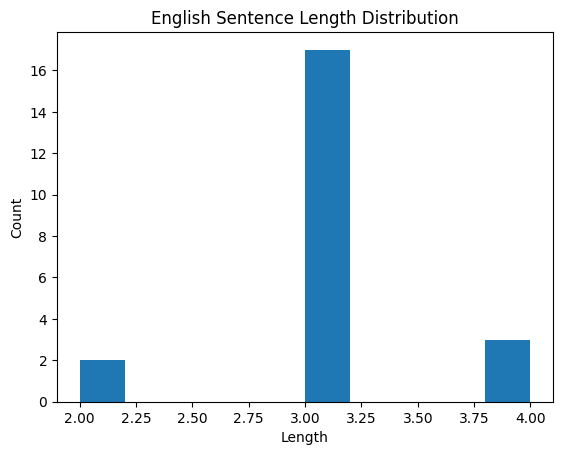

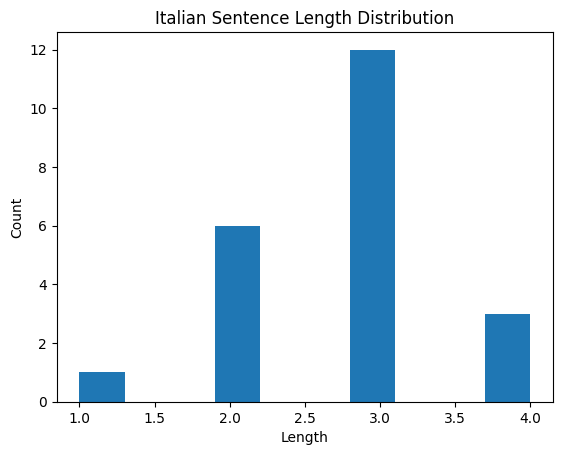

In [ ]:
# Sentence Length Distribution
eng_lengths = [len(p[0].split()) for p in pairs]
ita_lengths = [len(p[1].split()) for p in pairs]

plt.figure()
plt.hist(eng_lengths)
plt.title("English Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(ita_lengths)
plt.title("Italian Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()


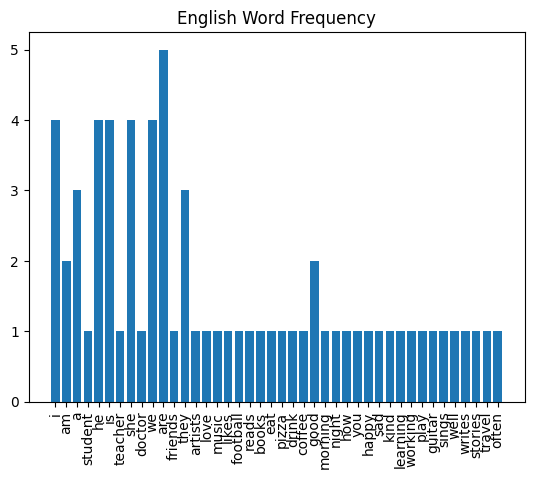

In [ ]:
# Word Frequency
eng_words = " ".join([p[0] for p in pairs]).split()
freq = Counter(eng_words)

plt.figure()
plt.bar(freq.keys(), freq.values())
plt.title("English Word Frequency")
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden


In [ ]:
# Attention Decoder
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=10):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]),1)), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]),1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)

        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weights

In [ ]:
# Training Function
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, max_length=10):

    encoder_hidden = torch.zeros(1,1,encoder.hidden_size, device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Encode
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0,0]

    # Decode
    decoder_input = torch.tensor([[0]], device=device)
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        # IMPORTANT FIX HERE
        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))

        decoder_input = target_tensor[di].unsqueeze(0)

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
# Training
hidden_size = 256
encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, output_lang.n_words).to(device)

enc_opt = optim.SGD(encoder.parameters(), lr=0.01)
dec_opt = optim.SGD(decoder.parameters(), lr=0.01)

criterion = nn.NLLLoss()

print("Training Started")

for epoch in range(400):

    total_loss = 0

    for eng, ita in pairs:
        input_tensor = torch.tensor([input_lang.word2index[w] for w in eng.split()], device=device)
        target_tensor = torch.tensor([output_lang.word2index[w] for w in ita.split()], device=device)

        loss = train(input_tensor, target_tensor, encoder, decoder,
                     enc_opt, dec_opt, criterion)

        total_loss += loss

    if (epoch + 1) % 40 == 0:
        print(f"Epoch {epoch+1}/400 completed | Loss: {total_loss:.4f}")

print("Training Completed")


Training Started
Epoch 40/400 completed | Loss: 2.1102
Epoch 80/400 completed | Loss: 0.5790
Epoch 120/400 completed | Loss: 0.3155
Epoch 160/400 completed | Loss: 0.2122
Epoch 200/400 completed | Loss: 0.1582
Epoch 240/400 completed | Loss: 0.1253
Epoch 280/400 completed | Loss: 0.1032
Epoch 320/400 completed | Loss: 0.0875
Epoch 360/400 completed | Loss: 0.0758
Epoch 400/400 completed | Loss: 0.0667
Training Completed


In [ ]:
# Testing
def translate(sentence):
    with torch.no_grad():
        input_tensor = torch.tensor([input_lang.word2index[w] for w in sentence.split()], device=device)
        encoder_hidden = torch.zeros(1,1,encoder.hidden_size, device=device)
        encoder_outputs = torch.zeros(10, encoder.hidden_size, device=device)

        for ei in range(len(input_tensor)):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0,0]

        decoder_input = torch.tensor([[0]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []

        for _ in range(10):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.topk(1)
            if topi.item() == 1:
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        return " ".join(decoded_words)

# Test example
print("Input: i am a student")
print("Output:", translate("i am a student"))

print("Input: she sings well")
print("Output:", translate("she sings well"))


Input: i am a student
Output: sono uno studente studente studente studente la chitarra musica pizza
Input: she sings well
Output: lei canta bene bene bene bene bene bene bene bene
